# Identical photos search
## Основная идея
Для создания сервиса поиска похожих фотографий нужен ансамбль из нейросети для фичеризации изображений и метода k ближайших соседей. Фотографии пользователя прогоняются через backbone нейросети для построения векторов, затем через полносвязные слои для сжатия размерности полученных векторов, а они уже в конце загоняются в алгоритм knn. Но есть проблема, которая заключается в выборе сети для векторизации изображений, ведь разные нейросети будут по разному извлекать признаки из фотографий. В решении этой проблемы помогут сиамские нейронные сети.
## Сиамская сеть
Сиамская нейронная сеть — это разновидность искусственной нейронной сети, которая состоит из двух идентичных нейронных подсетей с одинаковыми наборами весов. Данный вид сетей позволяет сравнить вектора признаков двух объектов с целью выделить их семантическое сходство или различие. Сиамская нейронная сеть представляет собой нелинейное отображение данных с целью приблизить друг к другу схожие объекты и разнести различные объекты на максимально возможное расстояние. [Источник](https://neerc.ifmo.ru/wiki/index.php?title=Сиамская_нейронная_сеть)

![Сиамская сеть](https://neerc.ifmo.ru/wiki/images/archive/0/00/20201227183632%21Siamese_neural_net.png) 

Таким образом, можно будет прогнать два изображения через одну и ту же сеть для векторизации, посмотреть на расстояние между векторами и принять решение о схожести данных фотографий.



In [ ]:
#@title Импорт зависимостей
import torch
import numpy as np
import PIL
from PIL import Image
import pandas as pd
import os
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
from torchvision import models
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm

In [ ]:
#@title Вычисляющее устройство
if torch.cuda.is_available():
  print('CUDA is available!')
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
  print('CUDA is not available(')
print('Training on', DEVICE)

CUDA is available!
Training on cuda


## Датасет для обучения
Обучение сиамской сети будет проводиться на датасете лиц знаменитостей с [kaggle](https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset).

В нём 17 знаменитостей, для каждой из которой есть 100 фотографий, кроме Scarlett Johansson. В этой папке было 200 фотографий, поэтому я удалил лишние 100. Готовый датасет можно взять на моём [GitHub](https://github.com/t041lk8/identical-photos-search/blob/develop/dataset/Celebrity%20Faces%20Dataset.zip).

In [ ]:
#@title Распаковка изображений
from google.colab import drive

#@markdown Если вы загрузили .zip архив на свой Google Drive, то поставьте галочку. Иначе загрузите архив в Colab и снимите галочку
enable_gdrive = True#@param {type:"boolean"}
if enable_gdrive:
  drive.mount('/content/gdrive/')
  os.system('unzip -q /content/gdrive/MyDrive/Celebrity\ Faces\ Dataset.zip -d /content/dataset/')
else:
  os.system('unzip -q /content/Celebrity\ Faces\ Dataset.zip -d /content/dataset/')

Для лучшего обучения нейросети количество идентичных и различных фотографий будет сблансировано 50/50. Все фотографии будут проходить через [препроцессинг](https://pytorch.org/vision/stable/models.html#using-the-pre-trained-models), соответсвующий весам каждой модели.

In [ ]:
class FaceDataset(Dataset):
  def __init__(self, root_dir, len, data_transforms = None):
    super().__init__()
    self.len = len  
    self.root_dir = root_dir
    self.data_transforms = data_transforms
    self.root_dir_list = self._parse_dir()
    self.dataset_list = self.generate_dataset()

  def _parse_dir(self):
    dir_list = []
    for dirpath, folders, _ in os.walk(self.root_dir):
      for folder in folders:
        for tmp, _, images in os.walk(os.path.join(dirpath, folder)):
          for image in images:
            dir_list += [os.path.join(tmp, image)]
    return dir_list
    
  def generate_dataset(self):
    np.random.seed(42)
    dataset_list = []
    for _ in range(int(self.len/2)):
      while True:
        ind1 = np.random.randint(17)
        ind2 = np.random.randint(17)
        if ind1 != ind2:
          break
      ind = np.random.randint(100)
      dataset_list += [(1, ind1, ind2, ind)]
    for _ in range(int(self.len/2)):
      while True:
        ind1 = np.random.randint(100)
        ind2 = np.random.randint(100)
        if ind1 != ind2:
          break
      ind = np.random.randint(17)
      dataset_list += [(0, ind1, ind2, ind)]
    return dataset_list

  def __len__(self):
    return self.len

  def prepare_sample(self, img_name):
    image = self.load_sample(img_name)
    image = self.data_transforms(image)
    return image

  def load_sample(self, file):
    image = Image.open(file).convert('RGB')
    image.load()
    return image
    
  def __getitem__(self, idx):
    sample = self.dataset_list[idx]
    label, ind1, ind2, ind = sample
    if label:
      img1 = self.prepare_sample(self.root_dir_list[ind1*100+ind])
      img2 = self.prepare_sample(self.root_dir_list[ind2*100+ind])
    else:
      img1 = self.prepare_sample(self.root_dir_list[ind*100+ind1])
      img2 = self.prepare_sample(self.root_dir_list[ind*100+ind2])
    return img1, img2, label

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt_ax.imshow(inp)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

## SiameseNetwork
Полносвязная нейронная сеть, сжимающая векторы и выступающая в роли сиамской сети.

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self, n_neurons):
    super(SiameseNetwork, self).__init__()
    
    self.fc1 = nn.Sequential(
        nn.Linear(n_neurons, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 8))
    
  def forward_once(self, x):
    return self.fc1(x)
    
  def forward(self, img1, img2):
    out1 = self.forward_once(img1)
    out2 = self.forward_once(img2)
    return out1, out2

## Loss-функция
В качестве loss-функции используется [Contrastive Loss](https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246).

![Contrastive Loss](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*MzI1WHBC501fsf27eHHCLQ.png)

где Y - метка схожести (Y=0 для идентичных и Y=1 для различных фотографий), m - допустимый предел для D - расстояния между векторами:

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*q4cvUKG83x91-uWR8JM2LA.png)

Если фотографии похожи, то второе слагаемое зануляется, и задача состоит в минимизации расстояния между векторами. В противном случае есть два варианта. Если расстояние между векторами превышает допустимый предел, то ничего минимизировать не нужно и функция возвратит ноль, иначе необходимо будет увеличивать это расстояние, чтобы оно было больше допустимого предела.

Таким образом данная функция должна помочь нейросети отдалить различные изображения друг от друга и сблизить похожие.

In [ ]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

    return loss_contrastive

## Обучение
Обучаться сиамская сеть будет 10 эпох. В качестве оптимизатора используется Adam, метрика - accuracy. Я считаю, что данную метрику можно использовать, так как наш датасет сбалансирован, также она характеризует качество модели, агрегированное по всем классам. Это полезно, так как классы для нас имеют одинаковое значение. К тому же она легко интерпретируема.

In [ ]:
def fit(model, SiamNet, n_neurons, margin = 1.0):
  val_accuracy_history = []
  val_loss_history = []
  loss = ContrastiveLoss(margin=margin)
  optimizer = torch.optim.Adam(SimNet.parameters(), betas=(0.9, 0.999), lr=3*1.0e-4)
  epochs = 10
  for epoch in tqdm(range(epochs)):
    SiamNet.train()
    for img1, img2, label in train_dataloader:
      optimizer.zero_grad()
        
      img1 = img1.to(DEVICE)
      img2 = img2.to(DEVICE)
      label = label.to(DEVICE)

      img1 = model(img1)
      img2 = model(img2)
      img1 = torch.reshape(img1, (BATCH_SIZE, n_neurons))
      img2 = torch.reshape(img2, (BATCH_SIZE, n_neurons))
      out1, out2 = SiamNet(img1, img2) 
        
      loss_value = loss(out1, out2, label)
      loss_value.backward()
        
      optimizer.step()
        
    with torch.no_grad():
      SiamNet.eval()
      val_loss = []
      val_accuracy = []
      for img1, img2, label in val_dataloader:
        img1 = img1.to(DEVICE)
        img2 = img2.to(DEVICE)
        label = label.to(DEVICE)
        
        img1 = model(img1)
        img2 = model(img2)
        img1 = torch.reshape(img1, (BATCH_SIZE, n_neurons))
        img2 = torch.reshape(img2, (BATCH_SIZE, n_neurons))
        out1, out2 = SiamNet(img1, img2)

        val_loss.append(loss(out1, out2, label).data.cpu())
    
        preds_dist = F.pairwise_distance(out1, out2)
        preds_dist = preds_dist.ravel()
        preds_labels = [1 if i < margin else 0 for i in preds_dist]
        val_accuracy.append(accuracy_score(preds_labels, label.data.cpu().tolist()))
    
    val_loss_history.append(sum(val_loss)/len(val_loss))
    val_accuracy_history.append(sum(val_accuracy)/len(val_accuracy))
    torch.cuda.empty_cache()
    print('Epoch ', epoch, 
          ', acc: ', val_accuracy_history[-1],
          ', loss: ', val_loss_history[-1])
    
  return val_loss_history, val_accuracy_history

### Модели фичеризации
В качестве нейронных сетей для векторизации изображения я буду использовать легкие сети, так как ограничен мощностями GoogleColab :(

Во время обучения для каждой сети будут скачиваться её лучшие веса. Уже для скаченных весов будет подтягиваться препроцессинг для фотографий, который передается датасету для подготовки изображений. Поскольку каждая нейросеть на выходе из backbone имеет свою размерность выходного слоя, сиамская сеть будет инициализироваться заново для каждой модели. 

In [ ]:
feat_models = [('efficientnet_b1', 1280),
               ('googlenet', 1024),
               ('vgg11', 25088),
               ('alexnet', 9216),
               ('resnet152', 2048)]

In [ ]:
BATCH_SIZE = 32
list_stats = []
for feat_model in feat_models:
  weights = models.get_model_weights(name=feat_model[0])
  model = models.get_model(name=feat_model[0], weights=weights.DEFAULT)
  preprocess = weights.DEFAULT.transforms()

  dataset_size = 2048
  train_size = dataset_size * 0.875
  val_size = dataset_size * 0.125
  train_val_data = FaceDataset('/content/dataset/Celebrity Faces Dataset', 
                               dataset_size, preprocess)
  train_data, val_data = random_split(dataset = train_val_data, 
                                      lengths = [int(train_size), int(val_size)], 
                                      generator=torch.Generator().manual_seed(42))
  train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle=True)
    

  model = torch.nn.Sequential(*(list(model.children())[:-1]))
  model = model.to(DEVICE)
  model.eval()
  SiamNet = SiameseNetwork(n_neurons=feat_model[1])
  SiamNet.to(DEVICE)

  print('Training SiamNet +', feat_model[0], '...')
  loss, acc = fit(model, SiamNet, feat_model[1], 1.0)
  path = 'SiamNet_and_' + feat_model[0]
  torch.save(SiamNet.state_dict(), path)
  list_stats = list_stats + [{'name': feat_model[0], 
                                    'loss': loss, 
                                    'acc':acc, 
                                    'weights_path': path}]
  torch.cuda.empty_cache()

Training SimNet +  efficientnet_b1 ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch  0 , acc:  0.640625 , loss:  tensor(0.1923)
Epoch  1 , acc:  0.66015625 , loss:  tensor(0.1667)
Epoch  2 , acc:  0.67578125 , loss:  tensor(0.1696)
Epoch  3 , acc:  0.69921875 , loss:  tensor(0.1611)
Epoch  4 , acc:  0.72265625 , loss:  tensor(0.1636)
Epoch  5 , acc:  0.71484375 , loss:  tensor(0.1615)
Epoch  6 , acc:  0.7421875 , loss:  tensor(0.1695)
Epoch  7 , acc:  0.7421875 , loss:  tensor(0.1694)
Epoch  8 , acc:  0.765625 , loss:  tensor(0.1590)
Epoch  9 , acc:  0.76171875 , loss:  tensor(0.1730)
Epoch  10 , acc:  0.74609375 , loss:  tensor(0.1703)
Epoch  11 , acc:  0.75390625 , loss:  tensor(0.1645)
Epoch  12 , acc:  0.74609375 , loss:  tensor(0.1775)
Epoch  13 , acc:  0.7578125 , loss:  tensor(0.1701)
Epoch  14 , acc:  0.76171875 , loss:  tensor(0.1743)
Epoch  15 , acc:  0.75390625 , loss:  tensor(0.1826)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Training SimNet +  googlenet ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch  0 , acc:  0.6171875 , loss:  tensor(0.2167)
Epoch  1 , acc:  0.66015625 , loss:  tensor(0.2246)
Epoch  2 , acc:  0.65625 , loss:  tensor(0.2182)
Epoch  3 , acc:  0.64453125 , loss:  tensor(0.2104)
Epoch  4 , acc:  0.6484375 , loss:  tensor(0.2175)
Epoch  5 , acc:  0.671875 , loss:  tensor(0.2199)
Epoch  6 , acc:  0.671875 , loss:  tensor(0.2044)
Epoch  7 , acc:  0.671875 , loss:  tensor(0.2203)
Epoch  8 , acc:  0.65234375 , loss:  tensor(0.2076)
Epoch  9 , acc:  0.6484375 , loss:  tensor(0.2063)
Epoch  10 , acc:  0.625 , loss:  tensor(0.2033)
Epoch  11 , acc:  0.68359375 , loss:  tensor(0.2085)
Epoch  12 , acc:  0.671875 , loss:  tensor(0.2078)
Epoch  13 , acc:  0.66796875 , loss:  tensor(0.2012)
Epoch  14 , acc:  0.6484375 , loss:  tensor(0.2046)
Epoch  15 , acc:  0.71484375 , loss:  tensor(0.1967)


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Training SimNet +  vgg11 ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch  0 , acc:  0.56640625 , loss:  tensor(0.3014)
Epoch  1 , acc:  0.66796875 , loss:  tensor(0.2454)
Epoch  2 , acc:  0.6953125 , loss:  tensor(0.2497)
Epoch  3 , acc:  0.69140625 , loss:  tensor(0.2301)
Epoch  4 , acc:  0.703125 , loss:  tensor(0.2288)
Epoch  5 , acc:  0.69140625 , loss:  tensor(0.2464)
Epoch  6 , acc:  0.6953125 , loss:  tensor(0.2337)
Epoch  7 , acc:  0.6953125 , loss:  tensor(0.2639)
Epoch  8 , acc:  0.703125 , loss:  tensor(0.2546)
Epoch  9 , acc:  0.6953125 , loss:  tensor(0.2767)
Epoch  10 , acc:  0.70703125 , loss:  tensor(0.2616)
Epoch  11 , acc:  0.69921875 , loss:  tensor(0.2595)
Epoch  12 , acc:  0.70703125 , loss:  tensor(0.2710)
Epoch  13 , acc:  0.7109375 , loss:  tensor(0.2651)
Epoch  14 , acc:  0.7109375 , loss:  tensor(0.2525)
Epoch  15 , acc:  0.69921875 , loss:  tensor(0.2623)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Training SimNet +  alexnet ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch  0 , acc:  0.58984375 , loss:  tensor(0.3130)
Epoch  1 , acc:  0.60546875 , loss:  tensor(0.2402)
Epoch  2 , acc:  0.60546875 , loss:  tensor(0.2351)
Epoch  3 , acc:  0.64453125 , loss:  tensor(0.2447)
Epoch  4 , acc:  0.62890625 , loss:  tensor(0.2338)
Epoch  5 , acc:  0.64453125 , loss:  tensor(0.2346)
Epoch  6 , acc:  0.609375 , loss:  tensor(0.2711)
Epoch  7 , acc:  0.61328125 , loss:  tensor(0.2530)
Epoch  8 , acc:  0.65234375 , loss:  tensor(0.2655)
Epoch  9 , acc:  0.65234375 , loss:  tensor(0.2609)
Epoch  10 , acc:  0.66015625 , loss:  tensor(0.2663)
Epoch  11 , acc:  0.64453125 , loss:  tensor(0.2577)
Epoch  12 , acc:  0.66796875 , loss:  tensor(0.2903)
Epoch  13 , acc:  0.65234375 , loss:  tensor(0.2642)
Epoch  14 , acc:  0.6484375 , loss:  tensor(0.2582)
Epoch  15 , acc:  0.67578125 , loss:  tensor(0.2722)


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Training SimNet +  resnet152 ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch  0 , acc:  0.6640625 , loss:  tensor(0.1947)
Epoch  1 , acc:  0.703125 , loss:  tensor(0.1904)
Epoch  2 , acc:  0.703125 , loss:  tensor(0.1844)
Epoch  3 , acc:  0.70703125 , loss:  tensor(0.1880)
Epoch  4 , acc:  0.70703125 , loss:  tensor(0.2108)
Epoch  5 , acc:  0.70703125 , loss:  tensor(0.2233)
Epoch  6 , acc:  0.71875 , loss:  tensor(0.2284)
Epoch  7 , acc:  0.7109375 , loss:  tensor(0.2198)
Epoch  8 , acc:  0.73828125 , loss:  tensor(0.2515)
Epoch  9 , acc:  0.7265625 , loss:  tensor(0.2545)
Epoch  10 , acc:  0.7265625 , loss:  tensor(0.2463)
Epoch  11 , acc:  0.71875 , loss:  tensor(0.2638)
Epoch  12 , acc:  0.72265625 , loss:  tensor(0.2493)
Epoch  13 , acc:  0.71484375 , loss:  tensor(0.2682)
Epoch  14 , acc:  0.72265625 , loss:  tensor(0.2411)
Epoch  15 , acc:  0.72265625 , loss:  tensor(0.2651)


In [ ]:
import matplotlib.pyplot as plt

def print_stats(list_stats):
  figure, axis = plt.subplots(1, 2, figsize=(30, 5))
  for stats in list_stats:
    axis[0].plot(stats['acc'])
    axis[0].set_title('Accuracy ')
    axis[1].plot(stats['loss'])
    axis[1].set_title('Loss ')

  plt.show()

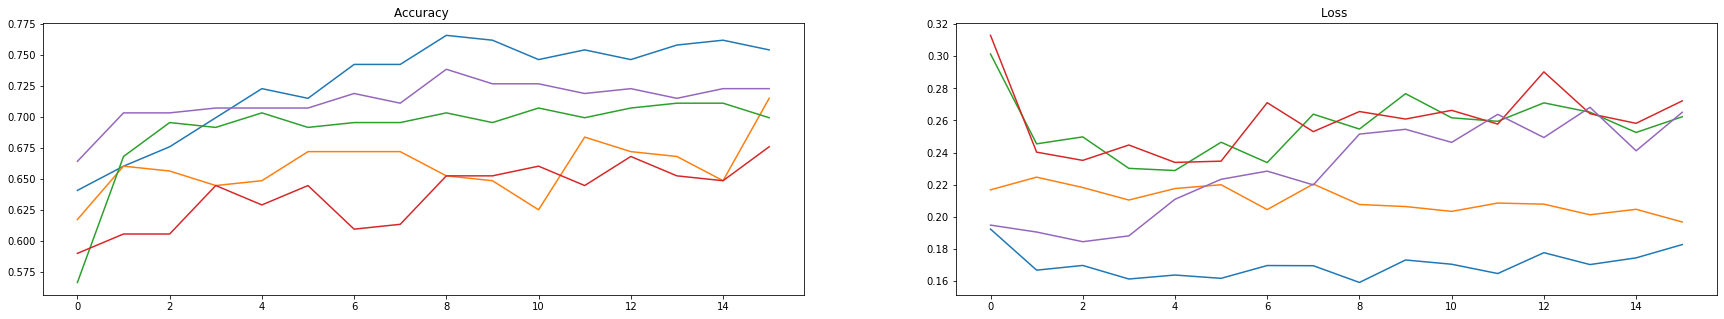

In [ ]:
print_stats(list_stats)